In [1]:
# import of standard python libraries
import numpy as np
import os
import time
import astropy.io.fits as pyfits

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import pandas as pd

import lenstronomy


# lenstronomy imports
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.ImSim.image_model import ImageModel
import lenstronomy.Util.param_util as param_util
import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
from lenstronomy.Util import kernel_util
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF

#import emcee for MCMC
import emcee

#import corner module with relevant installations for implementation
import corner

In [2]:
# Load the IllustrisTNG data

galaxy_data = pd.read_pickle('outputs/gravitational_potential_data_modular.pkl')

print("Available keys in galaxy_data:")
if 'galaxy_data' in locals():
    print(list(galaxy_data.keys()))



Available keys in galaxy_data:
['potential_3d', 'x_grid_3d', 'y_grid_3d', 'z_grid_3d', 'potential_2d_integrated', 'potential_2d_mean', 'potential_2d_weighted', 'grid_range', 'grid_resolution', 'grid_spacing_kpc', 'softening_kpc', 'gravitational_constant', 'computation_time_seconds', 'radius_cutoff_kpc', 'particles_used', 'total_particles_available', 'optimization_method', 'chunk_size', 'n_chunks', 'galaxy_center_coordinates', 'particle_mass_fraction_used']


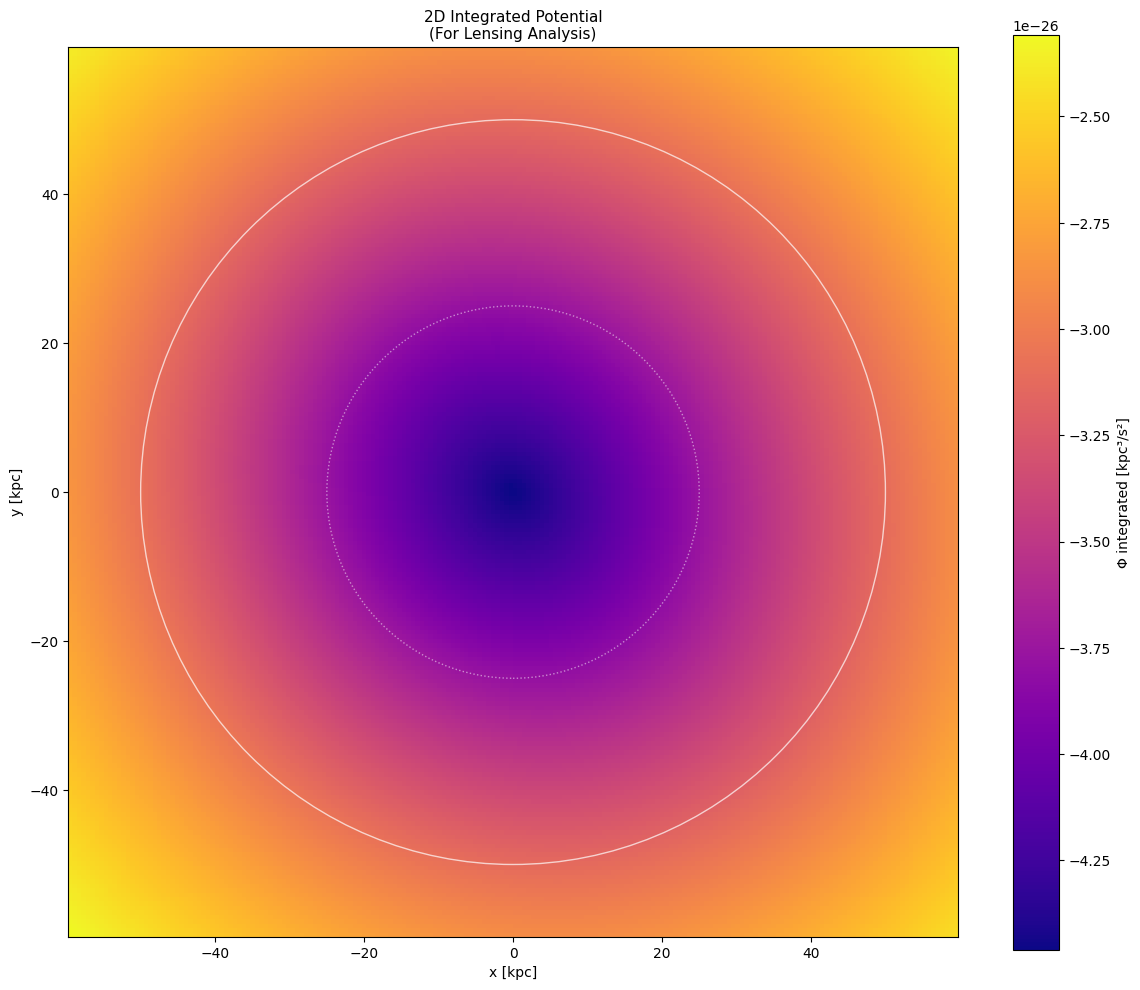

In [3]:
potential_2d_integrated = galaxy_data['potential_2d_integrated']
x_grid_3d = galaxy_data['x_grid_3d']
y_grid_3d = galaxy_data['y_grid_3d']


# Create 2D grid for plotting
x_2d = x_grid_3d[:, :, 0]
y_2d = y_grid_3d[:, :, 0]

fig, axes = plt.subplots(1, 1, figsize=(12, 10))
# Plot 1: 2D Integrated Potential (most important for lensing)
im1 = axes.imshow(potential_2d_integrated.T, origin='lower', 
                  extent=[x_2d.min(), x_2d.max(), y_2d.min(), y_2d.max()],
                  cmap='plasma', aspect='equal')
axes.set_title('2D Integrated Potential\n(For Lensing Analysis)', fontsize=11)
axes.set_xlabel('x [kpc]')
axes.set_ylabel('y [kpc]')
plt.colorbar(im1, ax=axes, label='Φ integrated [kpc³/s²]')


from matplotlib.patches import Circle
# Add reference circles to 2D plots
for ax in [axes]:
    # 50 kpc reference
    circle_50 = Circle((0, 0), 50, fill=False, color='white', 
                      linestyle='-', linewidth=1, alpha=0.7)
    ax.add_patch(circle_50)
    # 25 kpc reference  
    circle_25 = Circle((0, 0), 25, fill=False, color='white',
                      linestyle=':', linewidth=1, alpha=0.5)
    ax.add_patch(circle_25)

plt.tight_layout()
plt.show()

In [4]:
from astropy import units as u
parsec_value = 1 * u.pc
meter_value = parsec_value.to(u.m)
from astropy import constants as const
from astropy.cosmology import FlatLambdaCDM

# TNG cosmology parameters
H0 = 67.74  # km/s/Mpc (from TNG)
h = 0.6774  # Dimensionless Hubble parameter
Om0 = 0.3089  # Matter density parameter
Ode0 = 0.6911  # Dark energy density parameter

# Create cosmology object
cosmo = FlatLambdaCDM(H0=H0, Om0=Om0)

c = const.c.to(u.m/u.s).value  # Speed of light in m/s

# Cosmological and lensing parameters
z_lens = 0.3    # Lens (galaxy) redshift
z_source = 1.0  # Source redshift (background galaxy/quasar/source)

# Angular diameter distances using TNG cosmology
D_l = cosmo.angular_diameter_distance(z_lens).to(u.m).value  # Convert to meters, extract value
D_s = cosmo.angular_diameter_distance(z_source).to(u.m).value
D_ls = cosmo.angular_diameter_distance_z1z2(z_lens, z_source).to(u.m).value

print(D_l, D_s, D_ls)

lensing_potential = np.abs(potential_2d_integrated * (10**3 * meter_value.value)**3 * (D_ls/(D_l * D_s)) * 2/(c**2)) * 10**9

mean = np.mean(lensing_potential)
print(f"Mean Lensing Potential: {mean}")  

2.9239442615218382e+25 5.239806027369076e+25 3.3392422573798806e+25
Mean Lensing Potential: 0.4614333148184794


<>:9: SyntaxWarning: invalid escape sequence '\P'
<>:9: SyntaxWarning: invalid escape sequence '\P'
/var/folders/yb/5h1_fmpd1g3_5sy82wzy3q140000gn/T/ipykernel_54871/3048090144.py:9: SyntaxWarning: invalid escape sequence '\P'
  plt.colorbar(im1, ax=axes, label='lensing potential $\Psi$')


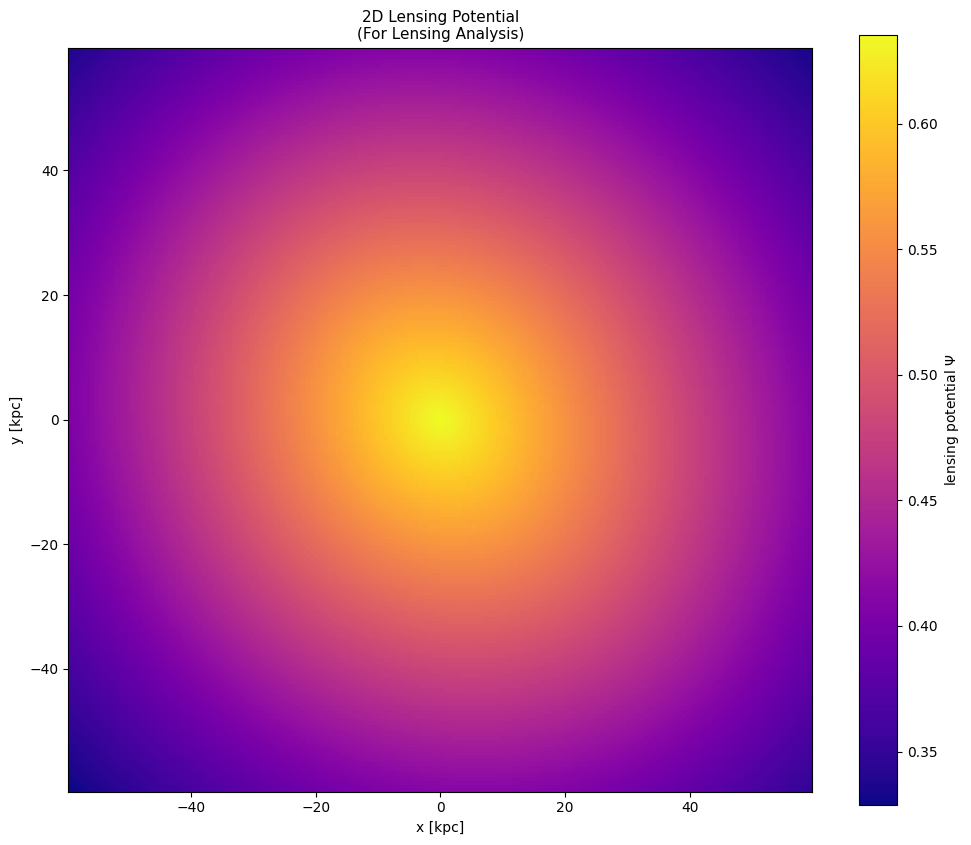

In [5]:
fig, axes = plt.subplots(1, 1, figsize=(12, 10))

im1 = axes.imshow(lensing_potential.T, origin='lower', 
                  extent=[x_2d.min(), x_2d.max(), y_2d.min(), y_2d.max()],
                  cmap='plasma', aspect='equal')
axes.set_title('2D Lensing Potential\n(For Lensing Analysis)', fontsize=11)
axes.set_xlabel('x [kpc]')
axes.set_ylabel('y [kpc]')
plt.colorbar(im1, ax=axes, label='lensing potential $\Psi$')

In [6]:
print(x_2d.shape, y_2d.shape, lensing_potential.shape)

(200, 200) (200, 200) (200, 200)


Angular scale: 1 arcsec = 4.594 kpc
Field of view: 26.0″ × 26.0″


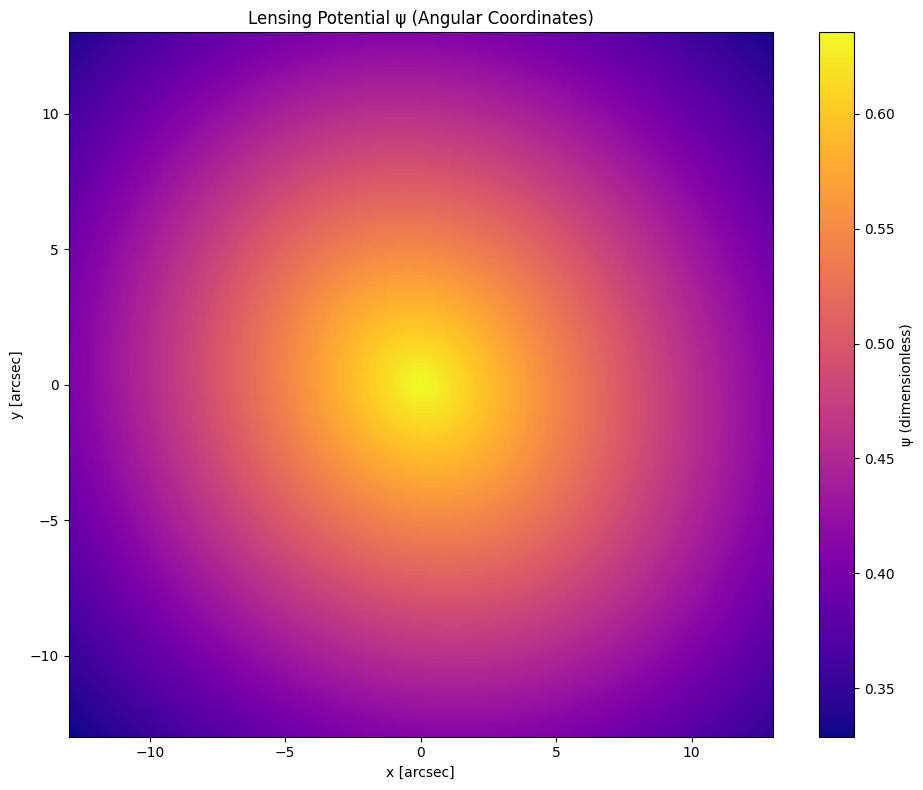

In [7]:
# Convert coordinates: kpc → arcseconds
D_l_kpc = D_l / (10**3 * meter_value.value)  # Angular diameter distance in kpc
x_2d_arcsec = (x_2d / D_l_kpc) * 206265  # Convert to arcsec
y_2d_arcsec = (y_2d / D_l_kpc) * 206265

# Angular scale and ranges
kpc_per_arcsec = D_l_kpc / 206265
print(f"Angular scale: 1 arcsec = {kpc_per_arcsec:.3f} kpc")
print(f"Field of view: {x_2d_arcsec.max()-x_2d_arcsec.min():.1f}″ × {y_2d_arcsec.max()-y_2d_arcsec.min():.1f}″")

# Plot with angular coordinates
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(lensing_potential.T, origin='lower', cmap='plasma', aspect='equal',
               extent=[x_2d_arcsec.min(), x_2d_arcsec.max(), y_2d_arcsec.min(), y_2d_arcsec.max()])
ax.set_xlabel('x [arcsec]'); ax.set_ylabel('y [arcsec]')
ax.set_title('Lensing Potential ψ (Angular Coordinates)')
plt.colorbar(im, label='ψ (dimensionless)')
plt.tight_layout(); plt.show()

In [8]:
# Calculate pixel size in arcseconds
print("=== PIXEL SIZE ANALYSIS ===")

# Physical pixel size from the grid
grid_range_kpc = x_2d.max() - x_2d.min()  # Total range in kpc
n_pixels = x_2d.shape[0]  # Number of pixels
physical_pixel_size_kpc = grid_range_kpc / n_pixels

print(f"Physical grid range: {grid_range_kpc:.1f} kpc")
print(f"Grid resolution: {n_pixels} × {n_pixels} pixels")
print(f"Physical pixel size: {physical_pixel_size_kpc:.3f} kpc/pixel")

# Convert to angular pixel size
angular_pixel_size_arcsec = (physical_pixel_size_kpc / D_l_kpc) * 206265

print(f"Angular pixel size: {angular_pixel_size_arcsec:.4f} arcsec/pixel")
print(f"This is equivalent to: {angular_pixel_size_arcsec*1000:.1f} mas/pixel")

# Store for use in deflection angle calculation
Delta_pix = angular_pixel_size_arcsec

print(f"\n✓ Delta_pix = {Delta_pix:.4f} arcsec/pixel (for deflection calculation)")

=== PIXEL SIZE ANALYSIS ===
Physical grid range: 119.4 kpc
Grid resolution: 200 × 200 pixels
Physical pixel size: 0.597 kpc/pixel
Angular pixel size: 0.1300 arcsec/pixel
This is equivalent to: 130.0 mas/pixel

✓ Delta_pix = 0.1300 arcsec/pixel (for deflection calculation)


=== CENTRAL 8×8 ARCSEC REGION SELECTION ===


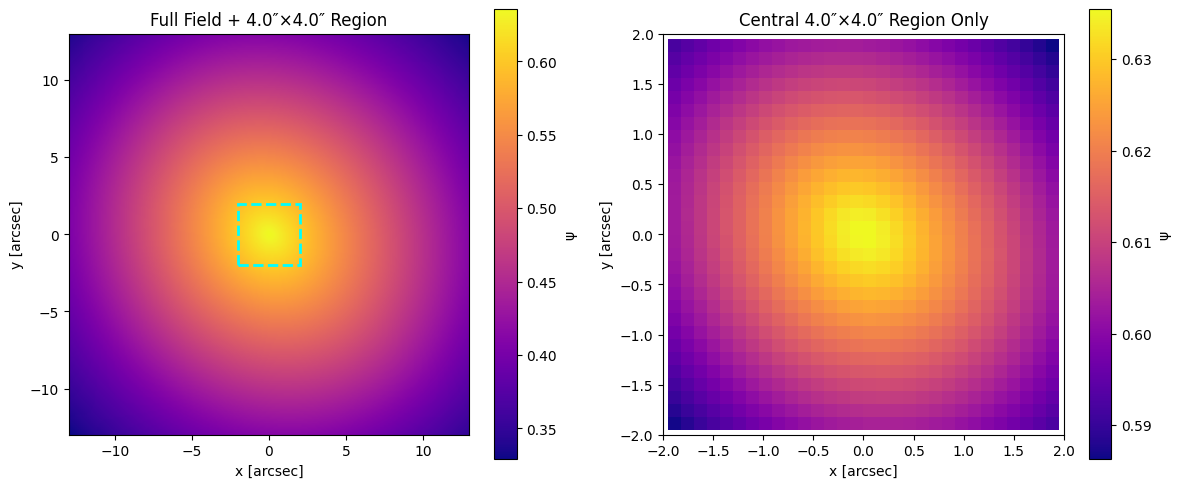


✓ Central 4.0″×4.0″ region data stored


In [9]:
# === CENTRAL 8×8 ARCSEC REGION SELECTION ===
print("=== CENTRAL 8×8 ARCSEC REGION SELECTION ===")

# Define central region size
central_size_arcsec = 4.0  # arcsec (8×8 arcsec square)

# Create mask for central square region
central_mask = (np.abs(x_2d_arcsec) <= central_size_arcsec/2) & (np.abs(y_2d_arcsec) <= central_size_arcsec/2)

# Extract central region data
lensing_potential_central = np.where(central_mask, lensing_potential, np.nan)

# Compact visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Full field with central region highlighted
im1 = ax1.imshow(lensing_potential.T, origin='lower', cmap='plasma', aspect='equal',
                 extent=[x_2d_arcsec.min(), x_2d_arcsec.max(), y_2d_arcsec.min(), y_2d_arcsec.max()])
# Draw square outline for central region
square = plt.Rectangle((-central_size_arcsec/2, -central_size_arcsec/2), central_size_arcsec, central_size_arcsec, 
                      fill=False, color='cyan', linewidth=2, linestyle='--')
ax1.add_patch(square)
ax1.set_xlabel('x [arcsec]'); ax1.set_ylabel('y [arcsec]')
ax1.set_title(f'Full Field + {central_size_arcsec}″×{central_size_arcsec}″ Region')
plt.colorbar(im1, ax=ax1, label='ψ')

# Central region only
im2 = ax2.imshow((lensing_potential_central).T, origin='lower', cmap='plasma', aspect='equal',
                 extent=[x_2d_arcsec.min(), x_2d_arcsec.max(), y_2d_arcsec.min(), y_2d_arcsec.max()])
ax2.set_xlim(-central_size_arcsec/2, central_size_arcsec/2)
ax2.set_ylim(-central_size_arcsec/2, central_size_arcsec/2)
ax2.set_xlabel('x [arcsec]'); ax2.set_ylabel('y [arcsec]')
ax2.set_title(f'Central {central_size_arcsec}″×{central_size_arcsec}″ Region Only')
plt.colorbar(im2, ax=ax2, label='ψ')

plt.tight_layout(); plt.show()

# Store central region data for further analysis
central_region_data = {
    'size_arcsec': central_size_arcsec,
    'mask': central_mask,
    'potential_2d': lensing_potential_central,
    'n_pixels': np.sum(central_mask)
}

print(f"\n✓ Central {central_size_arcsec}″×{central_size_arcsec}″ region data stored")

In [10]:
#lensing_potential_central = -np.log10(lensing_potential_central)

# Here, I define a custom function to compute deflection angles from the lensing potential by calculating the gradient of the potential map.
def potential_to_deflection(potential, delta_pix):
    """
    Compute deflection angles (α_x, α_y) from lensing potential.
    """
    alpha_y, alpha_x = np.gradient(potential, delta_pix)  # dψ/dx, dψ/dy
    return alpha_x, alpha_y

#%%

alpha_x_custom, alpha_y_custom = potential_to_deflection(lensing_potential_central, Delta_pix)


In [11]:
#%% data specifics
sigma_bkg = .05  #  background noise per pixel (Gaussian)
exp_time = 5000.  #  exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
numPix = 500  #  cutout pixel size
deltaPix = Delta_pix  #  pixel size in arcsec (area per pixel = deltaPix**2)
fwhm = 0.1  # full width half max of PSF (only valid when psf_type='gaussian')
psf_type = 'GAUSSIAN'  # 'GAUSSIAN', 'PIXEL', 'NONE'
kernel_size = 91

# initial input simulation

# generate the coordinate grid and image properties
kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, sigma_bkg)
data_class = ImageData(**kwargs_data)

# generate the psf variables

kwargs_psf = {'psf_type': psf_type, 'pixel_size': deltaPix, 'fwhm': fwhm}
psf_class = PSF(**kwargs_psf)

/var/folders/yb/5h1_fmpd1g3_5sy82wzy3q140000gn/T/ipykernel_54871/2317444847.py:95: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(image_sim), origin='lower', vmin=v_min, vmax=v_max, cmap=cmap, extent=[0, 1, 0, 1])


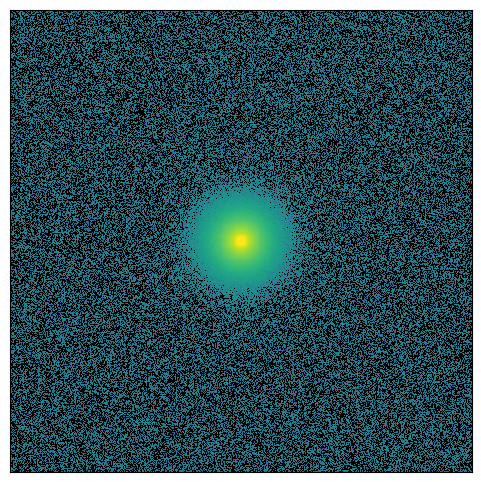

In [14]:
# %% Set up the Input Model
numPix = lensing_potential.shape[0]
x_angular = np.linspace(-numPix/2 * Delta_pix, numPix/2 * Delta_pix, numPix)
y_angular = np.linspace(-numPix/2 * Delta_pix, numPix/2 * Delta_pix, numPix)

# lensing quantities

lens_model_list = ['INTERPOL']
kwargs_lens = [{ 'grid_interp_x': x_angular,
    'grid_interp_y': y_angular,
    'f_' : lensing_potential_central,
    'f_x': alpha_x_custom,
    'f_y': alpha_y_custom
}]


lens_model_class = LensModel(lens_model_list=lens_model_list, z_lens=z_lens, z_source=z_source, cosmo=cosmo)




# choice of source type
source_type = 'SERSIC'  # 'SERSIC' or 'SHAPELETS'

source_x =0.1
source_y = 2



# list of light profiles (for lens and source)
# 'SERSIC': Sersic profile of source

phi_G, q = 0.5, 0.8
#e1, e2 = param_util.phi_q2_ellipticity(phi_G, q)
kwargs_sersic_source = {'amp': 4000, 'R_sersic': 0.2, 'n_sersic': 1, 'e1': 0, 'e2': 0, 'center_x': source_x, 'center_y': source_y}
source_model_list = ['SERSIC_ELLIPSE']
kwargs_source = [kwargs_sersic_source]
source_model_class = LightModel(light_model_list=source_model_list)


# lens light model
#phi_G, q = 0.9, 0.9
#e1, e2 = param_util.phi_q2_ellipticity(phi_G, q)
kwargs_sersic_lens = {'amp': 2000, 'R_sersic': 1, 'n_sersic': 2., 'e1': 0, 'e2': 0, 'center_x': 0.0, 'center_y': 0}
lens_light_model_list = ['SERSIC_ELLIPSE']
kwargs_lens_light = [kwargs_sersic_lens]
lens_light_model_class = LightModel(light_model_list=lens_light_model_list)

# Lensed Image positions

lensEquationSolver = LensEquationSolver(lens_model_class)
x_image, y_image = lensEquationSolver.findBrightImage(source_x, source_y, kwargs_lens, numImages=4,
                                                      min_distance=deltaPix, search_window=numPix * deltaPix)
mag = lens_model_class.magnification(x_image, y_image, kwargs=kwargs_lens)
kwargs_ps = [{'ra_image': x_image, 'dec_image': y_image,
                           'point_amp': np.abs(mag)*1000}]  # quasar point source position in the source plane and intrinsic brightness
point_source_list = ['LENSED_POSITION']
point_source_class = PointSource(point_source_type_list=point_source_list, fixed_magnification_list=[False])

kwargs_numerics = {'supersampling_factor': 1}

imageModel = ImageModel(data_class, psf_class, lens_model_class, 
                                source_model_class,
                                lens_light_model_class, point_source_class, kwargs_numerics=kwargs_numerics)

# generate image
image_sim = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light, kwargs_ps)
poisson = image_util.add_poisson(image_sim, exp_time=exp_time)
bkg = image_util.add_background(image_sim, sigma_bkd=sigma_bkg)
image_sim = image_sim + bkg + poisson

#%%

data_class.update_data(image_sim)
kwargs_data['image_data'] = image_sim


kwargs_model = {'lens_model_list': lens_model_list,
                 'lens_light_model_list': lens_light_model_list,
                 'source_light_model_list': source_model_list,
                'point_source_model_list': point_source_list
                 }

# display the initial simulated image
cmap_string = 'viridis'
cmap = plt.get_cmap(cmap_string)
cmap.set_bad(color='k', alpha=1.)
cmap.set_under('k')

v_min = -4
v_max = 2

f, axes = plt.subplots(1, 1, figsize=(6, 6), sharex=False, sharey=False)
ax = axes
im = ax.matshow(np.log10(image_sim), origin='lower', vmin=v_min, vmax=v_max, cmap=cmap, extent=[0, 1, 0, 1])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)
plt.show()

In [15]:
print(type(lens_model_class))

<class 'lenstronomy.LensModel.lens_model.LensModel'>


/var/folders/yb/5h1_fmpd1g3_5sy82wzy3q140000gn/T/ipykernel_54871/2657140529.py:54: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(kappa_obs.T), origin='lower', cmap='inferno', extent=[-300, 300, -300, 300])


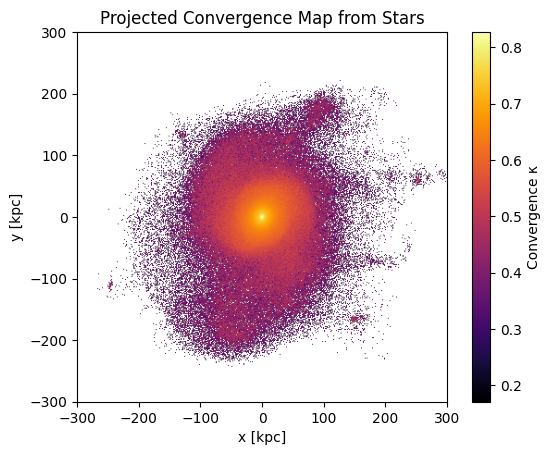

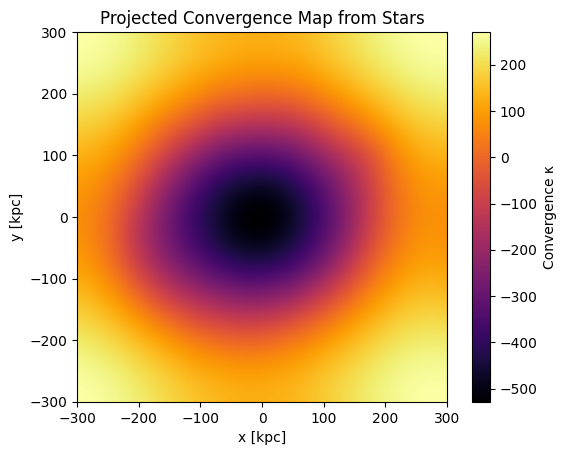

/var/folders/yb/5h1_fmpd1g3_5sy82wzy3q140000gn/T/ipykernel_54871/2657140529.py:264: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(image_sim), origin='lower', vmin=v_min, vmax=v_max, cmap=cmap, extent=[0, 1, 0, 1])


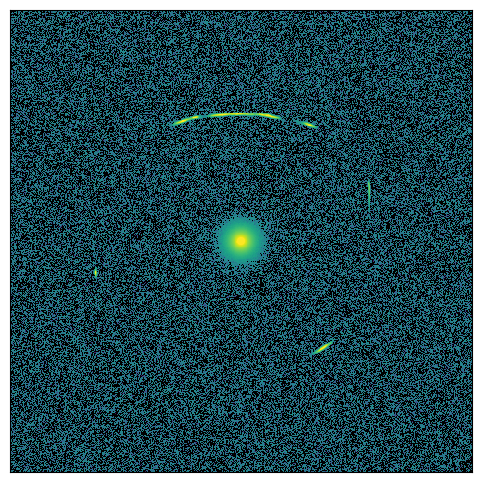

In [16]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Apr 29 23:53:24 2025

@author: abdullahalzaif
"""

# %%
# import of standard python libraries
import numpy as np
import os
import time
import astropy.io.fits as pyfits

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


import lenstronomy


# lenstronomy imports
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.ImSim.image_model import ImageModel
import lenstronomy.Util.param_util as param_util
import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
from lenstronomy.Util import kernel_util
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF

#import emcee for MCMC
import emcee

#import corner module with relevant installations for implementation
import corner

#%%

from lenstronomy.LensModel.Profiles.interpol import Interpol

kappa_obs = np.load("/Users/abdullahalzaif/Desktop/PIII_Project_Strong_Lensing/IllustrisTNG/kappa_observed.npy", allow_pickle=True)

x_coord = np.load("/Users/abdullahalzaif/Desktop/PIII_Project_Strong_Lensing/IllustrisTNG/x_coord.npy", allow_pickle=True)

y_coord = np.load("/Users/abdullahalzaif/Desktop/PIII_Project_Strong_Lensing/IllustrisTNG/y_coord.npy", allow_pickle=True)

#%%

plt.imshow(np.log10(kappa_obs.T), origin='lower', cmap='inferno', extent=[-300, 300, -300, 300])
plt.colorbar(label='Convergence κ')
plt.xlabel('x [kpc]')
plt.ylabel('y [kpc]')
plt.title('Projected Convergence Map from Stars')
plt.show()

#%%

x_pos =[i+0.6 for i in x_coord]
y_pos =[i+0.6 for i in y_coord]

x_pos = x_pos[:500]
y_pos = y_pos[:500]


delta_x  = 1.0 #kpc
D_ang_lens = 1297.04084139 #Mpc
delta_rad = 2 * np.arctan((delta_x*10**3)/(2*D_ang_lens * 10**6)) 


Delta_pix = delta_rad * 206264.806 #arcseconds

x_ang_max, x_ang_min = 300*Delta_pix, -300*Delta_pix


#%%
import numpy as np
from numpy.fft import fft2, ifft2, fftfreq

def kappa_to_potential(kappa_map, pixel_size_arcsec):
    """
    Convert a convergence (κ) map to lensing potential (ψ) using Fourier transforms.
    
    Parameters:
    - kappa_map: 2D numpy array of convergence values.
    - pixel_size_arcsec: pixel scale in arcseconds.

    Returns:
    - potential_map: 2D numpy array of lensing potential ψ.
    """
    n = kappa_map.shape[0]
    L = n * pixel_size_arcsec  # total angular size
    dk = 1.0 / L

    kx = fftfreq(n, d=pixel_size_arcsec)
    ky = fftfreq(n, d=pixel_size_arcsec)
    kx, ky = np.meshgrid(kx, ky)

    k2 = kx**2 + ky**2
    k2[0, 0] = 1.0  # avoid divide by zero at DC

    kappa_ft = fft2(kappa_map)
    psi_ft = -2 * kappa_ft / (4 * np.pi**2 * k2)  # Note 4π² from FFT convention
    psi_ft[0, 0] = 0.0  # subtract mean, zero potential at DC mode

    potential_map = np.real(ifft2(psi_ft))
    return potential_map


#%%

lensing_pot = kappa_to_potential(kappa_obs, Delta_pix)

numPix = lensing_pot.shape[0]
x_angular = np.linspace(-numPix/2 * Delta_pix, numPix/2 * Delta_pix, numPix)
y_angular = np.linspace(-numPix/2 * Delta_pix, numPix/2 * Delta_pix, numPix)

#%%
plt.imshow((lensing_pot), origin='lower', cmap='inferno', extent=[-300, 300, -300, 300])
plt.colorbar(label='Convergence κ')
plt.xlabel('x [kpc]')
plt.ylabel('y [kpc]')
plt.title('Projected Convergence Map from Stars')
plt.show()

#%%

def potential_to_deflection(potential, delta_pix):
    """
    Compute deflection angles (α_x, α_y) from lensing potential.
    """
    alpha_y, alpha_x = np.gradient(potential, delta_pix)  # dψ/dx, dψ/dy
    return alpha_x, alpha_y

#%%

alpha_x, alpha_y = potential_to_deflection(lensing_pot, Delta_pix)


# %% define lens configuration and cosmology (not for lens modelling)

z_lens = 0.5
z_source = 2.0
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.)


#%% data specifics
sigma_bkg = .05  #  background noise per pixel (Gaussian)
exp_time = 5000.  #  exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
numPix = 500  #  cutout pixel size
deltaPix = Delta_pix  #  pixel size in arcsec (area per pixel = deltaPix**2)
fwhm = 0.1  # full width half max of PSF (only valid when psf_type='gaussian')
psf_type = 'GAUSSIAN'  # 'GAUSSIAN', 'PIXEL', 'NONE'
kernel_size = 91

# initial input simulation

# generate the coordinate grid and image properties
kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, sigma_bkg)
data_class = ImageData(**kwargs_data)

# generate the psf variables

kwargs_psf = {'psf_type': psf_type, 'pixel_size': deltaPix, 'fwhm': fwhm}
psf_class = PSF(**kwargs_psf)



# %% Set up the Input Model

# lensing quantities

lens_model_list = ['INTERPOL']
kwargs_lens = [{ 'grid_interp_x': x_angular,
    'grid_interp_y': y_angular,
    'f_' : lensing_pot,
    'f_x': alpha_x,
    'f_y': alpha_y
}]


lens_model_class = LensModel(lens_model_list=lens_model_list, z_lens=z_lens, z_source=z_source, cosmo=cosmo)




# choice of source type
source_type = 'SERSIC'  # 'SERSIC' or 'SHAPELETS'

source_x =0.05
source_y = 0.1



# list of light profiles (for lens and source)
# 'SERSIC': Sersic profile of source

phi_G, q = 0.5, 0.8
#e1, e2 = param_util.phi_q2_ellipticity(phi_G, q)
kwargs_sersic_source = {'amp': 4000, 'R_sersic': 0.2, 'n_sersic': 1, 'e1': 0, 'e2': 0, 'center_x': source_x, 'center_y': source_y}
source_model_list = ['SERSIC_ELLIPSE']
kwargs_source = [kwargs_sersic_source]
source_model_class = LightModel(light_model_list=source_model_list)


# lens light model
#phi_G, q = 0.9, 0.9
#e1, e2 = param_util.phi_q2_ellipticity(phi_G, q)
kwargs_sersic_lens = {'amp': 8000, 'R_sersic': 0.4, 'n_sersic': 2., 'e1': 0, 'e2': 0, 'center_x': 0.0, 'center_y': 0}
lens_light_model_list = ['SERSIC_ELLIPSE']
kwargs_lens_light = [kwargs_sersic_lens]
lens_light_model_class = LightModel(light_model_list=lens_light_model_list)

# Lensed Image positions

lensEquationSolver = LensEquationSolver(lens_model_class)
x_image, y_image = lensEquationSolver.findBrightImage(source_x, source_y, kwargs_lens, numImages=4,
                                                      min_distance=deltaPix, search_window=numPix * deltaPix)
mag = lens_model_class.magnification(x_image, y_image, kwargs=kwargs_lens)
kwargs_ps = [{'ra_image': x_image, 'dec_image': y_image,
                           'point_amp': np.abs(mag)*1000}]  # quasar point source position in the source plane and intrinsic brightness
point_source_list = ['LENSED_POSITION']
point_source_class = PointSource(point_source_type_list=point_source_list, fixed_magnification_list=[False])

kwargs_numerics = {'supersampling_factor': 1}

imageModel = ImageModel(data_class, psf_class, lens_model_class, source_model_class,
                                lens_light_model_class, point_source_class, kwargs_numerics=kwargs_numerics)

# generate image
image_sim = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light, kwargs_ps)
poisson = image_util.add_poisson(image_sim, exp_time=exp_time)
bkg = image_util.add_background(image_sim, sigma_bkd=sigma_bkg)
image_sim = image_sim + bkg + poisson

#%%

data_class.update_data(image_sim)
kwargs_data['image_data'] = image_sim


kwargs_model = {'lens_model_list': lens_model_list,
                 'lens_light_model_list': lens_light_model_list,
                 'source_light_model_list': source_model_list,
                'point_source_model_list': point_source_list
                 }

# display the initial simulated image
cmap_string = 'viridis'
cmap = plt.get_cmap(cmap_string)
cmap.set_bad(color='k', alpha=1.)
cmap.set_under('k')

v_min = -4
v_max = 2

f, axes = plt.subplots(1, 1, figsize=(6, 6), sharex=False, sharey=False)
ax = axes
im = ax.matshow(np.log10(image_sim), origin='lower', vmin=v_min, vmax=v_max, cmap=cmap, extent=[0, 1, 0, 1])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)
plt.show()